# FFR120 Simulation of Complex Systems - Crowd Disasters
**Group** - Team Butterflies

**Members**:
- Artur ..
- Maria
- Nina
- Ruiqi
- Rundong .,

In [60]:
from dataclasses import dataclass
import numpy as np
import sklearn.preprocessing


@dataclass(init=True)
class SimState:
    def __init__(self, positions, velocities, forces, person_states): 
        self.positions: np.ndarray = positions
        self.velocities: np.ndarray = velocities
        self.forces: np.ndarray = forces
        self.person_states: np.ndarray = person_states
            
        
    def copy(self):
        return SimState(
            positions = self.positions.copy(),
            velocities = self.velocities.copy(),
            forces = self.forces.copy(),
            person_states = self.person_states.copy()
        )
        
        
class Environment:    
    # A rectangle is defined as (botleft, botright, topright, topleft)
    
    # Walls are defined as a set of points,
    # thus the total shape becomes (n_corners, n_dim)
    # example: rectangular obstacles -> shape=(4, 2)
    walls: list[np.ndarray] = [
        np.array([[0, 0], [50, 0], [50, 2], [0, 2]]),
        np.array([[48, 2], [50, 2], [50, 48], [48, 48]]),
        np.array([[0, 48], [50, 48], [50, 50], [0, 50]]),
        np.array([[0, 2], [2, 2], [2, 48], [0, 48]]),
        
    ]
        
    wall_face: list[np.ndarray] = [
        np.array([0, 1]),
        np.array([-1, 0]),
        np.array([0, -1]),
        np.array([1, 0])
    ]
        
    # Exits are defined as rectangular,
    # and thus behave in the same way as walls
    exits: np.ndarray = np.array([
        [[40, 24], [51, 24], [51, 26], [40, 26]]
    ])
        
    
class PersonState:
    living = 0
    exited = 1
    dead = 2
        
    
class SimConstants:
    time_inc = 0.02
    n_individuals = 300
    individual_radius = 0.5
    collision_rebound = 100
    mass = 10
    max_pos = 50, 50
    simulation_time = 10
    damping_constant = 0
    start_margin = 0.1
    
    n_time_steps = int(simulation_time/time_inc)
    force_scalar = time_inc/mass
    
        
        
class AnimationSettings:
    display_size = 8, 8   # Size of display in inches
    dpi = 100    # Pixels per inch
    bg_color = "#C336C9"
    individual_color = "#000000"
    framerate = 30
    exit_color = "#00FF00"
    wall_color = "000000"
    
    def get_marker_size():
        return AnimationSettings.dpi*np.mean(AnimationSettings.display_size)*SimConstants.individual_radius/np.mean(SimConstants.max_pos)

## Simulation


In [61]:
def get_environmental_force(individual, state) -> float:
    """Net forces acting on an individual caused by the environment"""
    
    # Compute the displacement between this individual and all others, |p_i - p_j|.
    displacements = state.positions[individual, :] - state.positions

    # The distance to each individual is the norm of each displacement |p_i - p_j|.
    distances = np.linalg.norm(displacements, axis=1)

    # Find all the collisions that occur, which is defined as the instances
    # where the distances are within 2 radiuses, since this means that each
    # perimeter is just barely touching.
    # Exclude the instances where the distance is 0, since this means that
    # the individual is being compared to itself (or something has gone terribly wrong):
    collisions = (
        (distances < 2*SimConstants.individual_radius) &
        (distances > 0)
    )

    net_environmental_force = np.sum(SimConstants.collision_rebound / displacements[collisions], axis=0)
    
    return net_environmental_force

In [62]:
def get_social_force(individual, state) -> float:
    """Net forces acting on an individual caused by the environment"""

    velocity = state.velocities[individual]
    damping_force = -np.sign(velocity) * (velocity*velocity.T) * SimConstants.damping_constant
    
    net_social_force = damping_force
    
    return net_social_force

In [63]:
def get_overlap_individuals_with_rectangle(positions, rectangle):
    # First check if bounding box of individual overlaps with the rectangle
    bbox_botleft = positions - SimConstants.individual_radius
    bbox_topright = positions + SimConstants.individual_radius
    
    i_rect_overlap = np.where(
        (bbox_botleft[:, 0] > rectangle[0, 0]) &
        (bbox_topright[:, 0] < rectangle[2, 0]) &
        (bbox_botleft[:, 1] > rectangle[0, 1]) &
        (bbox_topright[:, 1] < rectangle[2, 1])
    )
    
    # TODO:
    # Now see if circle overlaps
    # https://www.baeldung.com/cs/circle-line-segment-collision-detection
    
    return i_rect_overlap


def get_touching_individuals_with_rectangle(positions, rectangle):
    # First check if bounding box of individual touches the rectangle
    bbox_botleft = positions - SimConstants.individual_radius
    bbox_topright = positions + SimConstants.individual_radius
    
    i_rect_overlap = np.where(
        (bbox_topright[:, 0] > rectangle[0, 0]) &
        (bbox_botleft[:, 0] < rectangle[2, 0]) &
        (bbox_topright[:, 1] > rectangle[0, 1]) &
        (bbox_botleft[:, 1] < rectangle[2, 1])
    )
    
    # TODO:
    # Now see if circle touches
    # https://www.baeldung.com/cs/circle-line-segment-collision-detection
    
    return i_rect_overlap
    

In [64]:
import numpy as np

def run_simulation(seed: int = None) -> list[SimState]:   
    np.random.seed(seed)
    rng = np.random.default_rng(seed=seed)

    max_pos = np.array(SimConstants.max_pos)
    shape_2d = (SimConstants.n_individuals, 2)
    shape_1d = (SimConstants.n_individuals,)

    state = SimState(
        positions = (
            SimConstants.start_margin * max_pos +
            np.random.rand(*shape_2d) * max_pos * (1-2*SimConstants.start_margin)
        ),
        #velocities=np.zeros(shape=shape_2d),
        velocities=np.array([0,-10])*np.ones(shape=shape_2d),
        forces=np.zeros(shape=shape_2d),
        person_states=np.zeros(shape=shape_1d)
    )
    
    history = [state.copy()]
    
    for time_step in range(SimConstants.n_time_steps):
        if (time_step+1) % 100 == 0:
            print(f"Time step: {time_step}/{SimConstants.n_time_steps-1}")
            state.person_states[rng.integers(SimConstants.n_individuals)] = PersonState.dead
            
        active = state.person_states == PersonState.living
        
        state.positions[active] = state.positions[active] + state.velocities[active] * SimConstants.time_inc
        state.forces = np.zeros(shape=shape_2d)

        for individual in range(SimConstants.n_individuals): 
            if not active[individual]:
                continue
                
            state.forces[individual] += get_environmental_force(individual, state)
            state.forces[individual] += get_social_force(individual, state)

        #moving_directions = state.velocities / np.linalg.norm(state.velocities, axis=1).reshape(-1, 1)
        for wall, wall_face in zip(Environment.walls, Environment.wall_face):
            i_colliding = get_touching_individuals_with_rectangle(state.positions, wall)
            #overlap = #np.dot(state.velocities[i_colliding, :], wall_face)
            overlap = (
                wall_face[0]*state.velocities[i_colliding, 0] +
                wall_face[1]*state.velocities[i_colliding, 1]
            )
            state.forces[i_colliding] -= wall_face*overlap.T * SimConstants.collision_rebound
            
            
        state.velocities[active] = (
            state.velocities[active] +
            state.forces[active] * SimConstants.force_scalar
        )
        
        i_exiting = get_overlap_individuals_with_rectangle(state.positions, Environment.exits[0])
        state.person_states[i_exiting] = PersonState.exited
        
        history.append(state.copy())


    return history


In [65]:
history_temp = run_simulation()


Time step: 99/499
Time step: 199/499
Time step: 299/499
Time step: 399/499
Time step: 499/499


## Animation

<IPython.core.display.Javascript object>


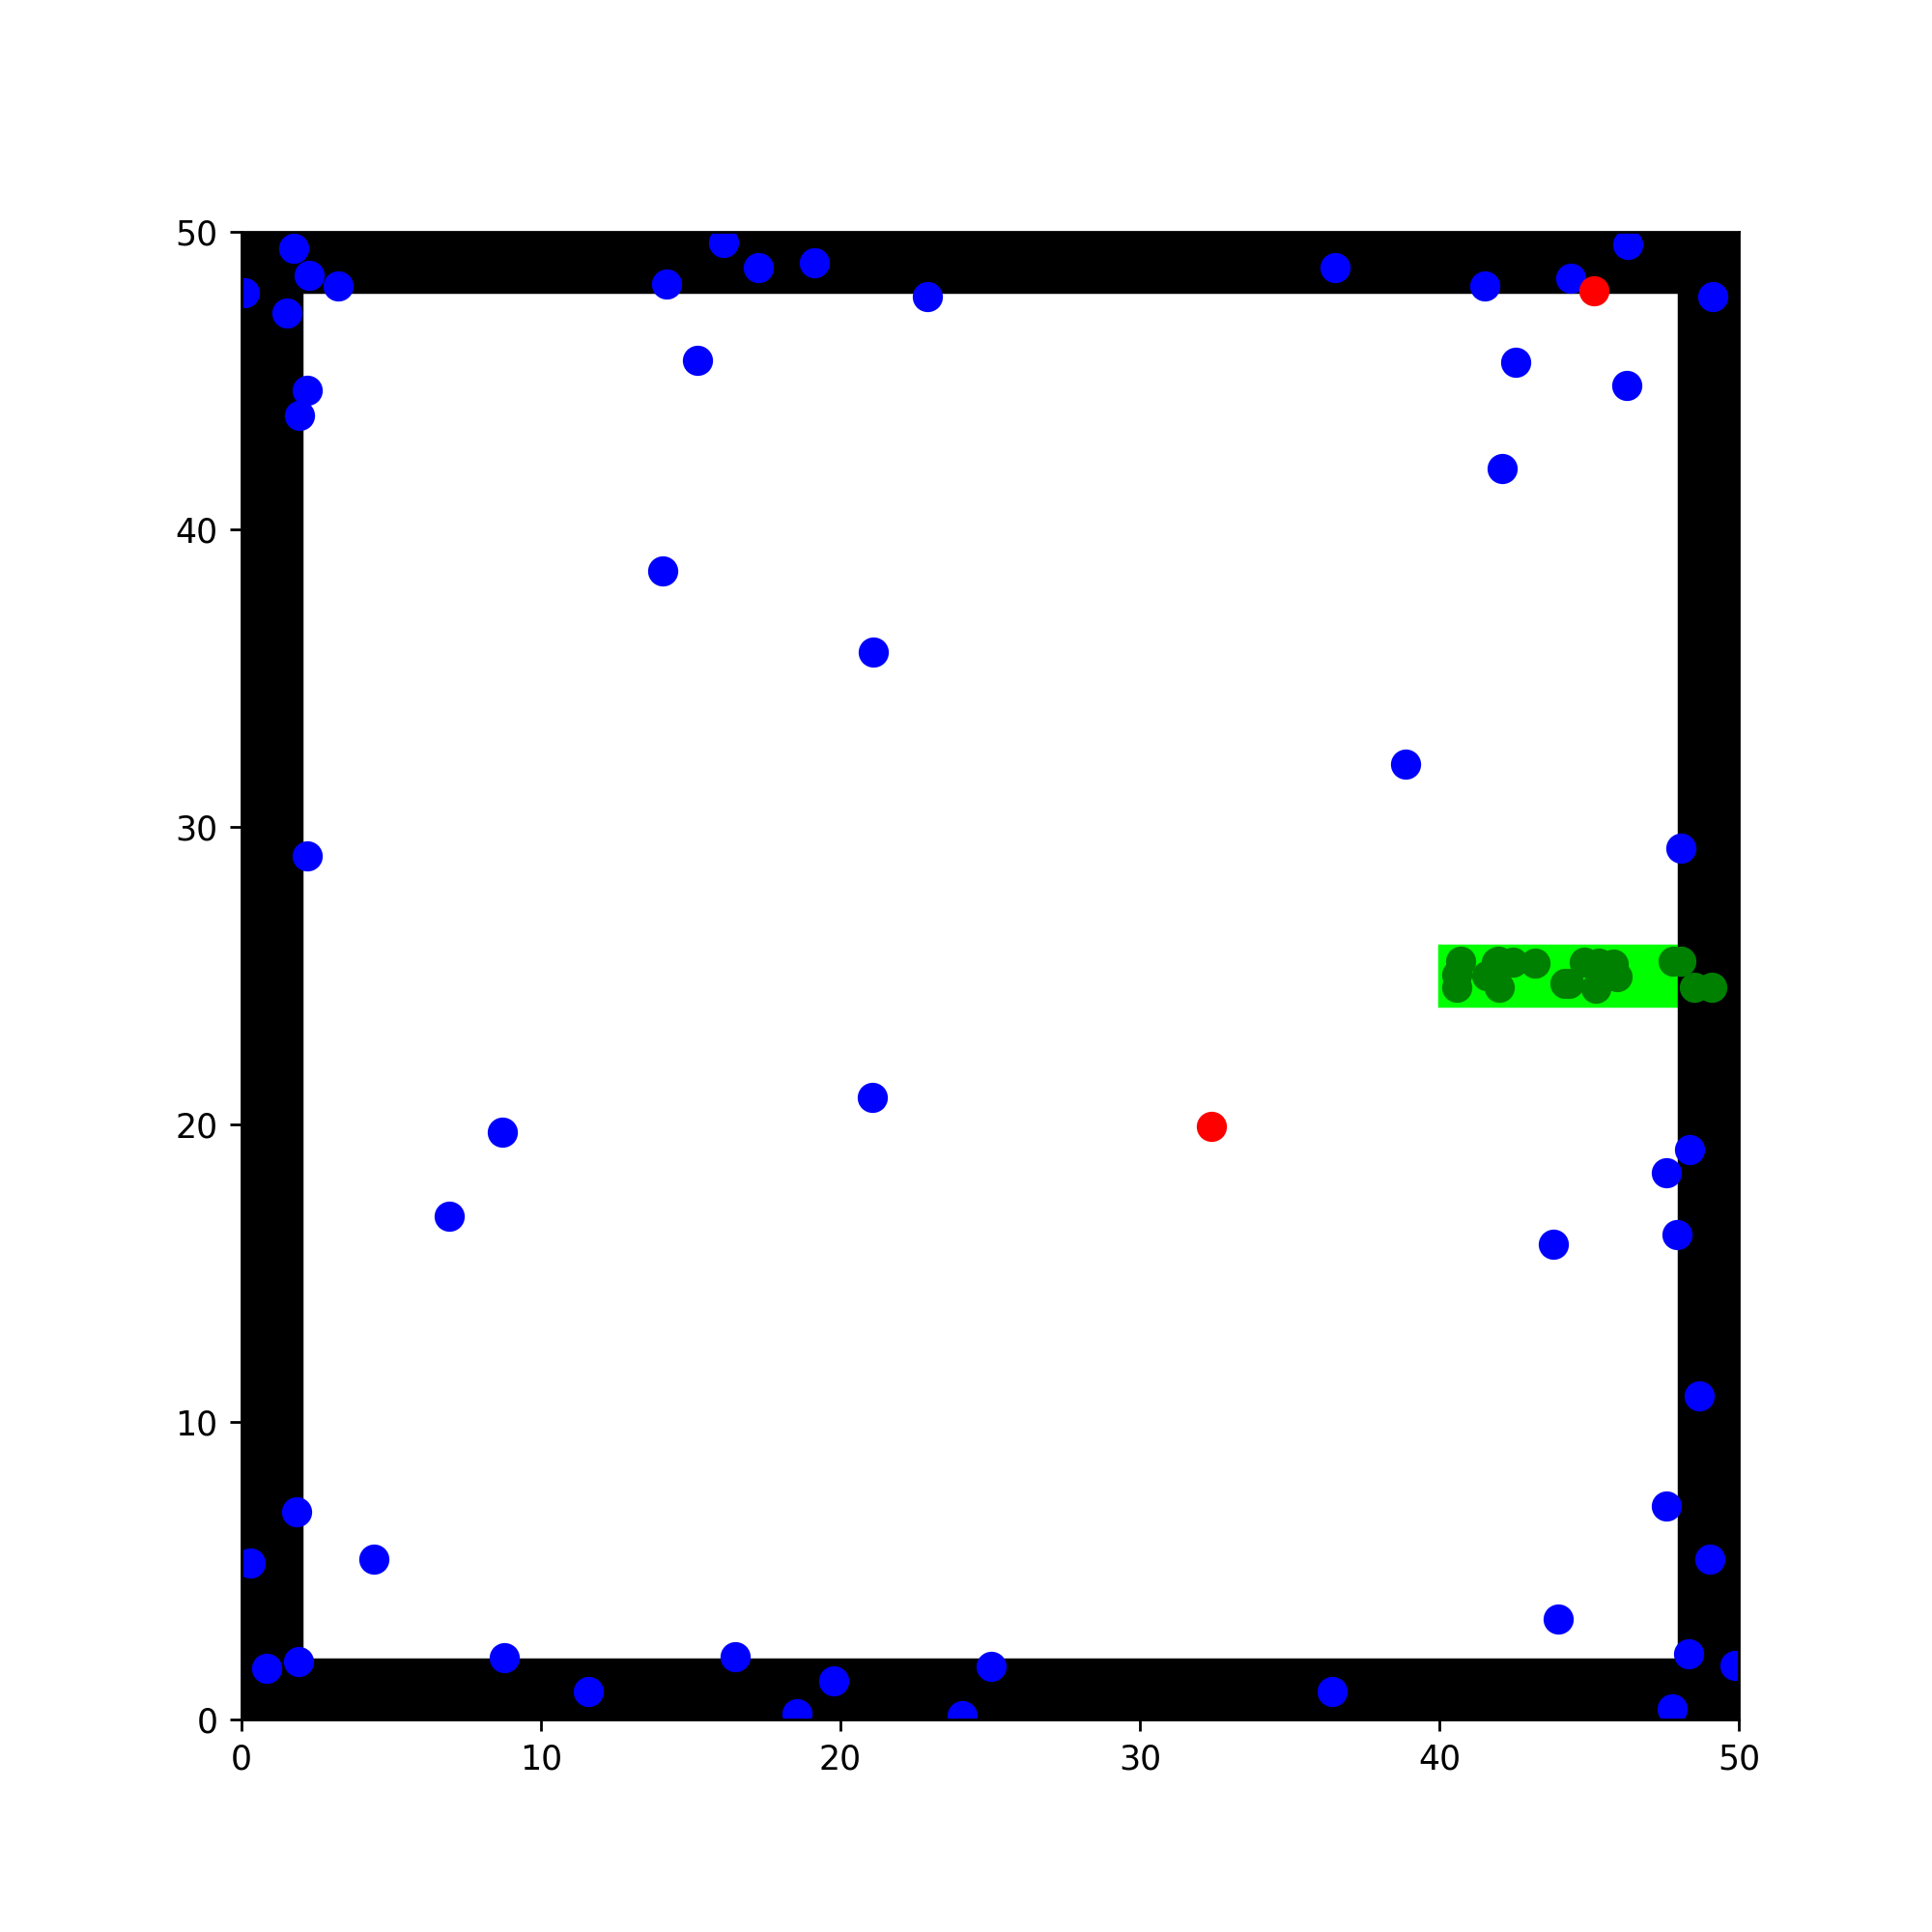

In [66]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.patches as patches


def get_time_step(i_frame: int, frame_rate: int, time_inc: float) -> int:
    """Get the time step corresponding to actual time passed of simulation.

    Example:
        50 fps -> 0.02s per frame
        0.01 time_inc -> 2 time steps per frame
        3 frames -> 6 time_steps

    Args:
        i_frame: The frame currently being rendered:
        frame_rate: Number of frames rendered per second.
        time_inc: The time passed between time steps.
    """
    return int((i_frame / frame_rate) / time_inc)


def get_rectangle_pos_and_size_for_patch(rect) -> tuple[np.ndarray, float, float]:
    """Extract position, width, and height from the rectangle.
    
    Each rectangle is defined by the points (topleft, topright, botright, botleft).
    A patch is defined by the (botleft, width, height).
    """
    
    pos = rect[0, :]
    w = rect[2, 0]-rect[0, 0]
    h = rect[2, 1]-rect[0, 1]
    return pos, w, h 


def render_state(i_frame, fig, history, screen_live, screen_dead, screen_exit):
    i_time = get_time_step(i_frame, AnimationSettings.framerate, SimConstants.time_inc)
    state = history[i_time]
    
    pos_dead = state.positions[state.person_states == PersonState.dead]
    screen_dead.set_data(pos_dead[:, 0], pos_dead[:, 1])
    
    pos_exit = state.positions[state.person_states == PersonState.exited]
    screen_exit.set_data(pos_exit[:, 0], pos_exit[:, 1])
    
    pos_live = state.positions[state.person_states == PersonState.living]
    screen_live.set_data(pos_live[:, 0], pos_live[:, 1])
        
    return screen_live, screen_dead, screen_exit


def render_simulation(history: list[SimState]) -> None:
    fig = plt.figure(
        figsize=AnimationSettings.display_size,
        dpi=AnimationSettings.dpi
    )
    ax = fig.gca()
    screen_live, = ax.plot([], [], 'bo', ms=AnimationSettings.get_marker_size())
    screen_dead, = ax.plot([], [], 'ro', ms=AnimationSettings.get_marker_size())
    screen_exit, = ax.plot([], [], 'go', ms=AnimationSettings.get_marker_size())
    
    for exit in Environment.exits:
        exit = patches.Rectangle(
            *get_rectangle_pos_and_size_for_patch(exit),
            color=AnimationSettings.exit_color
        )
        ax.add_patch(exit)
        
    for wall in Environment.walls:
        wall = patches.Rectangle(
            *get_rectangle_pos_and_size_for_patch(wall),
            color=AnimationSettings.wall_color
        )
        ax.add_patch(wall)
    
    ax.set_xlim(0, SimConstants.max_pos[0])
    ax.set_ylim(0, SimConstants.max_pos[1])
        
    animation = anim.FuncAnimation(
        fig=fig, func=render_state, frames=len(history),
        fargs=(fig, history, screen_live, screen_dead, screen_exit),
        blit=True, interval=int(1000/AnimationSettings.framerate)
    )
    return animation
    
animation = render_simulation(history_temp)


## Save data